In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [2]:
from Utils import get_data,generate_signals,result_analysis
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 60
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
import itertools
import datetime
from matplotlib.ticker import FormatStrFormatter

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Data Downloading

In [3]:
Crypto_daily_category=['BTC','ETH','DASH','DOGE','LTC','MAID','XMR','XRP','NEO','EOS','ZEC']

In [4]:
Crypto_daily = get_data.cryptocurrency()
data_dict=Crypto_daily.daily_price_historical(Crypto_daily_category)

#### Data Cleaning

In [5]:
for i in data_dict.keys():
    print(i,len(data_dict[i]))
    print(data_dict[i].index[0],data_dict[i].index[-1])

BTC 3034
2010-07-16 2018-11-04
ETH 1187
2015-08-06 2018-11-04
DASH 1732
2014-02-07 2018-11-04
DOGE 1739
2014-01-31 2018-11-04
LTC 1839
2013-10-23 2018-11-04
MAID 1377
2015-01-28 2018-11-04
XMR 1377
2015-01-28 2018-11-04
XRP 1385
2015-01-20 2018-11-04
NEO 458
2017-08-04 2018-11-04
EOS 495
2017-06-28 2018-11-04
ZEC 739
2016-10-27 2018-11-04


In [6]:
start_date=data_dict['NEO'].index[0]

In [7]:
for i in data_dict.keys():
    data_dict[i]=data_dict[i][data_dict[i].index>=start_date]

In [8]:
for i in range(len(Crypto_daily_category)):
    index=Crypto_daily_category[i]
    data_dict[index]['date']=data_dict[index].index
    data_dict[index]['value']=data_dict[index].close
    data_dict[index].drop(['open','high','low','close'],axis=1,inplace=True)
    data_dict[index].reset_index(drop=True,inplace=True)

In [9]:
#if date is all the same
for j,k in itertools.combinations(range(len(Crypto_daily_category)),2):
    if(sum(data_dict[Crypto_daily_category[j]].date!=\
              data_dict[Crypto_daily_category[k]].date)>0):
        print('Dates of dataset '+Crypto_daily_category[j]+' and '+\
              Crypto_daily_category[k]+' are different')
date=data_dict[list(data_dict.keys())[0]].date

In [10]:
data_df=pd.DataFrame()
for i in range(len(Crypto_daily_category)):
    index=Crypto_daily_category[i]
    data_df[index]=data_dict[index].value
data_df.index=data_dict[index].date

In [11]:
A_re_df=((data_df-data_df.shift(1))/data_df.shift(1)).dropna()

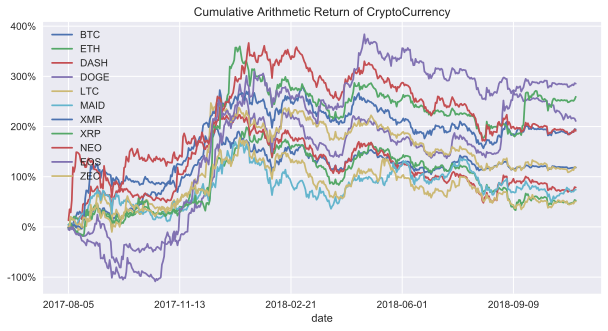

In [12]:
ax1=plt.subplot(111)
fmt='%.f%%'
ax1.yaxis.set_major_formatter(FormatStrFormatter(fmt))
A_re_cumsum=A_re_df.cumsum()*100
A_re_cumsum.plot(figsize=(10,5),ax=ax1)
plt.title('Cumulative Arithmetic Return of CryptoCurrency')
plt.show()

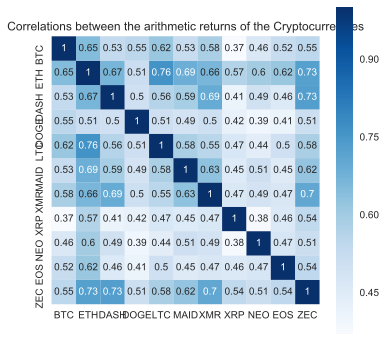

In [13]:
plt.subplots(figsize=(6,6))
sns.heatmap(A_re_df.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlations between the arithmetic returns of the Cryptocurrencies')
plt.show()

### Mean Reverting

#### Sinal Generating

In [15]:
ret=(np.log(data_df)-np.log(data_df.shift(1))).dropna()

In [16]:
signal_class=generate_signals.signal_2(ret)

In [17]:
signal_class.get_signal('max')

In [18]:
position=signal_class.signal_df

In [19]:
trade_ret=(ret.loc[position.index]*position).sum(axis=1)

In [21]:
for i in range(len(trade_ret)):
    if trade_ret[i]>0:
        position.iloc[i,:]=-position.iloc[i,:]

#### Result Analysis

In [22]:
return_sep=ret.loc[position.index].iloc[1:,:].values*position.iloc[:-1,:]

In [23]:
daily_re=return_sep.sum(axis=1)

In [24]:
re_a1=result_analysis.result_daily(daily_re,365)
re_a1.get_metrics()
print('Annualized Return: ',re_a1.ar)
print('Annualized SD: ',re_a1.std)
print('Annualized Sharp Ratio: ',re_a1.sp)
print('Maximum draw down: ',re_a1.mdd)

Annualized Return:  -0.438728506462
Annualized SD:  0.742193422115
Annualized Sharp Ratio:  -0.323172903814
Maximum draw down:  -0.712777476164


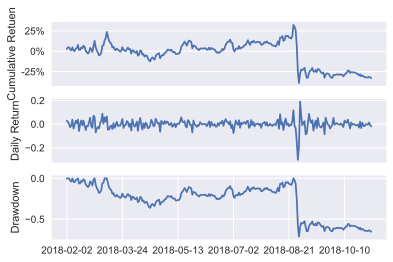

In [25]:
re_a1.figure_plot()

### Momentum

#### Signal Generating

In [29]:
signal_class.get_signal('min')

In [30]:
position=signal_class.signal_df
trade_ret=(ret.loc[position.index]*position).sum(axis=1)
for i in range(len(trade_ret)):
    if trade_ret[i]<0:
        position.iloc[i,:]=-position.iloc[i,:]

#### Result Analysis

In [31]:
return_sep=ret.loc[position.index].iloc[1:,:].values*position.iloc[:-1,:]
daily_re=return_sep.sum(axis=1)

In [32]:
re_a2=result_analysis.result_daily(daily_re,365)
re_a2.get_metrics()
print('Annualized Return: ',re_a2.ar)
print('Annualized SD: ',re_a2.std)
print('Annualized Sharp Ratio: ',re_a2.sp)
print('Maximum draw down: ',re_a2.mdd)

Annualized Return:  -0.479979066107
Annualized SD:  0.75233731098
Annualized Sharp Ratio:  -0.416621409646
Maximum draw down:  -0.937837538998


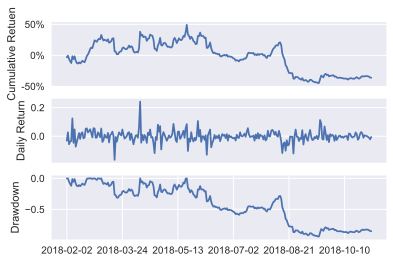

In [33]:
re_a2.figure_plot()